# Sentiment Analysis and Consumer Profiling

This script includes cleaning, EDA, feature creation, and some preliminary analysis. 

In [48]:
import pandas as pd
import numpy as np 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import matplotlib.patches as mpatches
import seaborn as sns
from textblob import TextBlob
from collections import Counter

In [49]:
food = pd.read_csv('./fastfood.csv', index_col=0)

In [50]:
food.shape

(48294, 14)

In [51]:
food = food.drop_duplicates()

In [52]:
food.shape

(44998, 14)

In [53]:
food.reset_index(inplace=True, drop=True)

In [54]:
#dropping all rows with all null values
food = food.drop(food[food.isnull().all(axis=1)].index[0], axis=0).reset_index(drop=True)

In [55]:
#Dropping all values that are not company related (initially only .0001% of observations)
to_drop = []

for row_num, val in enumerate(food['Company']):
    if val[0] != '@':
        to_drop.append(row_num)
        
food = food.drop(to_drop, axis=0).reset_index(drop=True)

In [56]:
#filling nulls and converting data types
food['user_is_verified'] = food['user_is_verified'].fillna(0).astype(int)
food['retweet_count'] = food.retweet_count.astype(int)

In [57]:
#Set to run Midnight and 5pm EST everyday, the times are in UTC, making EST
food['time_tweeted'] = pd.to_datetime(food['time_tweeted']) - pd.Timedelta(hours=4)

In [58]:
#shouldnt be removing stopwords before sentiment analysis:
#http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf
#testing different functions for preprocessing text for sentiment analysis

def Text_Cleaner_version_1(text):
    """Takes text, eliminates URLS, replaces contractions, tokenizes, 
    removes company names, lower cases, removes calls to twitter handles, 
    returns a string"""
    text = re.sub(r'(https)[^\s]+', '', text)
    text = re.sub(r'can\'t', 'can not', text)
    text = re.sub(r'don\'t', 'do not', text)
    text = re.sub(r'isn\'t', 'is not', text)
    text = re.sub(r'aren\'t', 'are not', text)
    text = re.sub(r'wasn\'t', 'was not', text)
    text = re.sub(r'weren\'t', 'were not', text)
    text = re.sub(r'haven\'t', 'have not', text)
    text = re.sub(r'\b(rt|RT)', '', text)
    text = re.sub(r'@[a-zA-Z0-9]+', '', text)
    text = re.sub('#', '', text)
    return text


def Text_Cleaner_version_2(text):
    """Takes text, eliminates URLS, replaces contractions, tokenizes, 
    removes company names, lower cases, removes calls to twitter handles, 
    returns a string, same as version 1, but only looking at words"""
    text = re.sub(r'(https)[^\s]+', '', text)
    text = re.sub(r'can\'t', 'can not', text)
    text = re.sub(r'don\'t', 'do not', text)
    text = re.sub(r'isn\'t', 'is not', text)
    text = re.sub(r'aren\'t', 'are not', text)
    text = re.sub(r'wasn\'t', 'was not', text)
    text = re.sub(r'weren\'t', 'were not', text)
    text = re.sub(r'haven\'t', 'have not', text)
    text = re.sub(r'\b(rt|RT)', '', text)
    text = re.sub(r'@[a-zA-Z0-9]+', '', text)
    text = re.sub('#', '', text)
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    return ' '.join(words)

#     LOOKING AT VARIOUS METHODS FOR PREPROCESSING FOR SENTIMENT ANALYSIS
#     tokenizer = RegexpTokenizer(r'\w+')
#     words = tokenizer.tokenize(text)
#     lower = [x.lower() for x in words]
#     words = [word for word in words if word != 'rt']
#     eliminator = [re.sub(r'(mcdon|dunki|denn|redro|sonic|starb|shakesh|domino|crackerb|chipot|wend)[a-z]+','',x)
#                   for x in lower]
#     return ' '.join(eliminator2)

In [67]:
#Created a test set of uncleaned data to check the value of the Text_Cleaner functions
food['text_sentiment_no_clean'] = food['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [60]:
#converting text with version 1
food['text_sentiment_v1'] = food['text'].apply(Text_Cleaner_version_1)
#Calculating sentiment with TextBlob
food['sentiment_score_v1'] = food['text_sentiment_v1'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [61]:
#converting text with version 2
food['text_sentiment_v2'] = food['text'].apply(Text_Cleaner_version_2)
#Calculating sentiment with TextBlob
food['sentiment_score_v2'] = food['text_sentiment_v2'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [63]:
#Looking at overall sentiment by company (version 1) (0 neutral, 1 positive, -1 negative)
food.groupby('Company')['sentiment_score_v1'].mean().sort_values()

Company
@dominos            0.061396
@dunkindonuts       0.097145
@wingstop           0.097767
@sonicdrivein       0.115606
@McDonalds          0.133439
@ChipotleTweets     0.137314
@redrobinburgers    0.139131
@Wendys             0.144204
@Potbelly           0.172345
@DennysDiner        0.182470
@Starbucks          0.192228
@CrackerBarrel      0.206900
@shakeshack         0.213786
Name: sentiment_score_v1, dtype: float64

In [64]:
#scores by version (2), very similar
food.groupby('Company')['sentiment_score_v2'].mean().sort_values()

Company
@dominos            0.061488
@dunkindonuts       0.085015
@wingstop           0.094806
@sonicdrivein       0.111552
@DennysDiner        0.121524
@McDonalds          0.130551
@ChipotleTweets     0.130741
@redrobinburgers    0.136322
@Wendys             0.143249
@Potbelly           0.167350
@CrackerBarrel      0.186701
@Starbucks          0.190803
@shakeshack         0.200835
Name: sentiment_score_v2, dtype: float64

In [68]:
food.groupby('Company')['text_sentiment_no_clean'].mean().sort_values()

Company
@dominos            0.061554
@dunkindonuts       0.097275
@wingstop           0.097741
@sonicdrivein       0.116341
@McDonalds          0.133608
@ChipotleTweets     0.136714
@redrobinburgers    0.138926
@Wendys             0.144241
@Potbelly           0.172286
@DennysDiner        0.182482
@Starbucks          0.194697
@CrackerBarrel      0.207498
@shakeshack         0.214941
Name: text_sentiment_no_clean, dtype: float64

In [69]:
#creating sentiment dummy variables 

def dummy_maker(val):
    """Takes in a float and returns a dummy based on the value
    to be used in pandas.apply"""
    if val == 0:
        return 0
    elif val > 0:
        return 1
    else:
        return -1

food['sentiment_dummies_v1'] = food['sentiment_score_v1'].apply(dummy_maker)

food['sentiment_dummies_v2'] = food['sentiment_score_v2'].apply(dummy_maker)

food['sentiment_dummies_uncleaned'] = food['text_sentiment_no_clean'].apply(dummy_maker)

# Continue examination of pretext cleaning for sentiment analysis below

In [66]:
print(food['sentiment_dummies_v1'].value_counts(), food['sentiment_dummies_v2'].value_counts())
#uncleaned isn't picking up anything positive

 1    20457
 0    18113
-1     6424
Name: sentiment_dummies_v1, dtype: int64  1    20216
 0    18327
-1     6451
Name: sentiment_dummies_v2, dtype: int64


In [43]:
#There are a 1000 differences in categorization between cleaned/uncleaned sentiments
disparities = food[~(food['sentiment_dummies_cleaned'] == food['sentiment_dummies_uncleaned'])].reset_index(drop=True)

#examining subset
for x in range(25):
    print(disparities['text'][x])
    print('Cleaned :', disparities['sentiment_dummies_cleaned'][x])
    print('Uncleaned :', disparities['sentiment_dummies_uncleaned'][x])
#some issues, but overall (and in other tests) the cleaned data is outperforming the uncleaned

@MartzMimic @sonicdrivein Sorry to hear it wasn't good for you. I wonder if it's an early days kind of problem.
Cleaned : -1
Uncleaned : 1
I was just informed @shakeshack is now on @Seamless ... RIP to my current wardrobe.
Cleaned : 0
Uncleaned : 1
@BoodhaB @shakeshack Hey, @DoorDash also delivers @shakeshack but unlike @Seamless @DoorDash does it properly and d… https://t.co/YNbAeByls2
Cleaned : 0
Uncleaned : 1
@e_skube @shakeshack @Seamless @ChickfilA BLESS UP
Cleaned : 0
Uncleaned : 1
@redrobinburgers you have the most@dysfunctional restaurant at the waterfront in pgh pa.   This place is a disaster… https://t.co/Y6WG2XNi0u
Cleaned : 1
Uncleaned : 0
@TuesdayStories @JoeListComedy @marknorm @ChipotleTweets @TheIBang @StandUpNY @laughable @MerchPump @TeamCoco Will DVR!
Cleaned : 0
Uncleaned : -1
@TuesdayStories @JoeListComedy @marknorm @ChipotleTweets @TheIBang @StandUpNY @laughable @MerchPump @TeamCoco Who is this??
Cleaned : 0
Uncleaned : -1
@dramosjr76 @Wendys @ChipotleTweets Are yo

In [16]:
#Looking at distribution of positivity/negativity throughout the day
positive_tweets = food.loc[food['sentiment_dummies'] == 1]
hourly_positivity = positive_tweets.groupby(positive_tweets['time_tweeted'].dt.hour)['Company'].count()

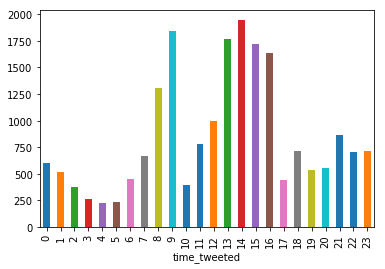

In [17]:
hourly_positivity.plot(kind='bar')

In [18]:
negative_tweets = food.loc[food['sentiment_dummies'] == -1]
hourly_negativity = negative_tweets.groupby(negative_tweets['time_tweeted'].dt.hour)['Company'].count()

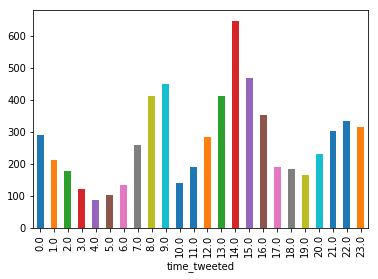

In [19]:
hourly_negativity.plot(kind='bar')

In [21]:
negativity_rate = hourly_negativity / (hourly_positivity + hourly_negativity)

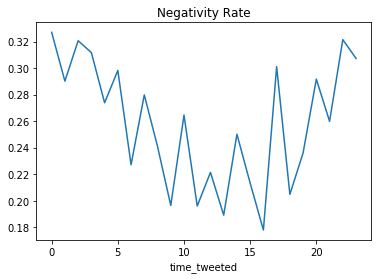

In [22]:
negativity_rate.plot(title='Negativity Rate')

In [24]:
#Numbe of retweets- this is a signifcant percentage of all tweets 
food.loc[food['text'].str[:2] == 'RT'].shape

(17783, 17)

In [25]:
without_retweets = food.loc[food['text'].str[:2] != 'RT'].reset_index(drop=True)

In [26]:
#customer profiles still skewed by large means- looking at medians
without_retweets.groupby('Company')[list(food.select_dtypes(include=np.number).columns)].median()

,favorite_count,number_of_people_they_follow,number_of_user_tweets,retweet_count,user_followers_count,user_is_verified,sentiment_score,sentiment_dummies
Company,,,,,,,,
@ChipotleTweets,0.0,356.0,4801.0,0,318.0,0,0.0,0
@CrackerBarrel,0.0,487.0,5596.0,0,376.0,0,0.0,0
@DennysDiner,0.0,272.5,3419.5,0,195.0,0,0.0,0
@McDonalds,0.0,320.0,3052.0,0,232.5,0,0.0,0
@Potbelly,0.0,483.0,8162.0,0,488.0,0,0.0,0
@Starbucks,0.0,374.5,5558.5,0,361.5,0,0.0,0
@Wendys,0.0,262.0,1225.0,0,146.0,0,0.0,0
@dominos,0.0,317.0,3888.0,0,249.0,0,0.0,0
@dunkindonuts,0.0,434.0,6883.0,0,390.5,0,0.0,0


In [28]:
without_retweets.shape

(27211, 17)

In [29]:
#a large number of the people tweet regularly at these companies 
without_retweets = without_retweets.drop_duplicates(subset=['Company', 'user_name'])
without_retweets.shape

(17212, 17)

In [33]:
#Characteristics of users tweeting at each company
without_retweets.groupby('Company')[list(food.select_dtypes(include=np.number).columns)[1:-3]].median()

,number_of_people_they_follow,number_of_user_tweets,retweet_count,user_followers_count
Company,,,,
@ChipotleTweets,332.0,4071.5,0,292.0
@CrackerBarrel,397.5,4012.0,0,272.0
@DennysDiner,261.0,2919.0,0,190.0
@McDonalds,305.0,2787.5,0,219.0
@Potbelly,392.5,4565.5,0,330.0
@Starbucks,359.0,5051.0,0,343.5
@Wendys,259.0,1191.0,0,146.0
@dominos,313.0,3389.0,0,246.0
@dunkindonuts,403.0,5686.0,0,333.0


In [27]:
#words that aren't caught that don't add value to function below
drop_words = ['love','don t', 'twitter', 'don', 'tweets', 'opinions', 'your',
             'born', 'never']

In [21]:
def Profile_Noun_Finder(text):
    """Takes text, eliminates non-alpha characters, and returns all nouns"""
    text = re.sub(r'(https)[^\s]+', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    lowered = [word.lower() for word in words]
    words = [word for word in lowered if len(word) > 2]
    words = [word for word in words if word not in drop_words]
    new_text = ' '.join(words)
    wiki = TextBlob(new_text)
    return list(wiki.noun_phrases)

## Positive Tweets

In [88]:
#getting rid of empty profiles
without_retweets = without_retweets.dropna(subset=['user_profile_text'])

#running function on profiles
without_retweets['nouns'] = without_retweets['user_profile_text'].apply(Profile_Noun_Finder)

#subsetting for positive reviews
positive_profiles = without_retweets.loc[without_retweets['sentiment_dummies'] == 1]

#flattening the list
flattened_nouns = [word for parts in positive_profiles['nouns'] for word in parts]

#looking at the 50 most common noun phrases
Counter(flattened_nouns).most_common(50)

In [94]:
#Creating word counts based on np_counts feature of text_blob
texters = ' '.join(positive_profiles['user_profile_text'])
dic_values = TextBlob(texters).np_counts
favorible_words = pd.DataFrame()
favorible_words['words'] = dic_values.keys()
favorible_words['count'] = dic_values.values()
favorible_words.sort_values(by='count', ascending=False)

## Negative Tweets

In [109]:
#subsetting for positive reviews
negative_profiles = without_retweets.loc[without_retweets['sentiment_dummies'] == -1]

#flattening the list
flattened_nouns = [word for parts in negative_profiles['nouns'] for word in parts]

#looking at the 50 most common noun phrases
Counter(flattened_nouns).most_common(50)

[('youtube channel', 7),
 ('social media', 4),
 ('new youtube', 3),
 ('personal account', 3),
 ('full time', 3),
 ('free time', 3),
 ('wife mom', 3),
 ('mhs tfa', 3),
 ('video games', 2),
 ('misanthropic attention whore talk', 2),
 ('music vinylpizza podcast writer', 2),
 ('link bio', 2),
 ('black man', 2),
 ('new things life', 2),
 ('chance waste', 2),
 ('everyday life', 2),
 ('proud mother', 2),
 ('parody account', 2),
 ('new products', 2),
 ('nintendo switch content', 2),
 ('animal lover', 2),
 ('gmail com', 2),
 ('proud father', 2),
 ('cool things', 2),
 ('news junkie animal lover', 2),
 ('culture addict theater', 2),
 ('news senior producer newhousesu grad retweets endorsements', 2),
 ('san diego', 2),
 ('stupid people', 2),
 ('union news press blogs jobs', 2),
 ('simple girl', 2),
 ('gon na', 2),
 ('social justice', 2),
 ('husband father', 2),
 ('wonderful children', 2),
 ('irony creator good music', 2),
 ('bad music keeper', 2),
 ('secret potato burrito sauce', 2),
 ('producer b

In [110]:
#Creating word counts based on np_counts feature of text_blob
texters = ' '.join(negative_profiles['user_profile_text'])
dic_values = TextBlob(texters).np_counts
favorible_words = pd.DataFrame()
favorible_words['words'] = dic_values.keys()
favorible_words['count'] = dic_values.values()
favorible_words.sort_values(by='count', ascending=False)

,words,count
29,love,37
149,twitter,27
167,ig,25
572,wife,24
176,god,23
772,instagram,21
538,husband,21
828,’ s,20
484,father,19
397,snapchat,18


# Dunkin vs. Starbucks

In [16]:
dunkin = food.loc[food['Company'] == '@dunkindonuts'] 
dunkin['hour'] = dunkin['time_tweeted'].dt.hour

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
dunkin.groupby('hour')['sentiment_score'].mean()

hour
0.0     0.055933
1.0     0.082589
2.0     0.165090
3.0     0.155026
4.0     0.083048
5.0     0.168492
6.0     0.096741
7.0     0.130059
8.0     0.068469
9.0     0.074440
10.0    0.066149
11.0    0.080584
12.0    0.062593
13.0    0.083717
14.0    0.072379
15.0    0.093971
16.0    0.116218
17.0    0.124282
18.0    0.110968
19.0    0.072887
20.0    0.037402
21.0    0.128900
22.0    0.096105
23.0    0.081113
Name: sentiment_score, dtype: float64

In [19]:
positive_dunkin = dunkin.loc[dunkin['sentiment_dummies'] == 1]

In [24]:
dunkin['user_profile_text'] = dunkin['user_profile_text'].fillna(' ')

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
dunkin['nouns'] = dunkin['user_profile_text'].apply(Profile_Noun_Finder)

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
positive_dunkin = dunkin.loc[dunkin['sentiment_dummies'] == 1]
negative_dunkin = dunkin.loc[dunkin['sentiment_dummies'] == -1]

In [45]:
nouns = []
for val in positive_dunkin['nouns']:
    if val:
        words = val[0]
        words = words.split()
        for word in words:
            nouns.append(word)

In [46]:
most_positive_dunk_words = Counter(nouns).most_common(50)

In [49]:
nouns = []
for val in negative_dunkin['nouns']:
    if val:
        words = val[0]
        words = words.split()
        for word in words:
            nouns.append(word)

In [51]:
negative_dunk_words = Counter(nouns).most_common(50)

In [52]:
dunkin

,Company,favorite_count,number_of_people_they_follow,number_of_user_tweets,retweet_count,text,time_tweeted,unique_code,user_coordinates,user_followers_count,user_is_verified,user_location,user_name,user_profile_text,text_sentiment,sentiment_score,sentiment_dummies,hour,nouns
5568,@dunkindonuts,0.0,1522.0,3695.0,0,@dunkindonuts #DDLuckyDozen and #Sweepstakes I...,2018-03-13 15:12:18,973637894563758080,NaN,220.0,0,WEST,JOAN DUCAR,,ddluckydozen and sweepstakes i will be spendi...,0.100000,1,15.0,[]
5569,@dunkindonuts,0.0,151.0,6780.0,0,@dunkindonuts drive-thru\nMe: “I’d like a cara...,2018-03-13 15:12:09,973637860791410690,NaN,475.0,0,NaN,JP,"Cast your burden on the Lord, & He will sustai...",drive thru me i d like a caramel iced coffee ...,0.000000,0,15.0,"[cast burden, airports mountains sweaters sock..."
5570,@dunkindonuts,0.0,842.0,19740.0,1,RT @Tessa_Roy: .@GovRaimondo arrives for storm...,2018-03-13 15:12:09,973637858278944768,NaN,10425.0,1,"Providence, RI",NewsTalk 99.7 & AM 630 WPRO,The Voice of Southern New England,tessa_roy govraimondo arrives for storm press ...,0.000000,0,15.0,"[voice southern, new england]"
5571,@dunkindonuts,0.0,601.0,3347.0,1,.@GovRaimondo arrives for storm press conferen...,2018-03-13 15:11:53,973637790683553793,NaN,695.0,0,"Providence, RI",Tessa Roy,"Reporter @wpro, alum @EmersonCollege. Snarky o...",govraimondo arrives for storm press conference...,0.000000,0,15.0,"[reporter wpro alum emersoncollege snarky, own..."
5572,@dunkindonuts,0.0,327.0,14179.0,17,RT @dunkindonuts: Standard. #Snowstorm https:/...,2018-03-13 15:11:39,973637731216773120,NaN,1516.0,0,"NY, NJ",Molly R. Blackwell,"New England raised me, NY is shaping me. ...",standard snowstorm,0.000000,0,15.0,"[new england, cape cod nyc, full picture]"
5573,@dunkindonuts,0.0,840.0,25660.0,17,RT @dunkindonuts: Standard. #Snowstorm https:/...,2018-03-13 15:10:48,973637519186292736,NaN,1058.0,0,Boston,Kevin,I'm just me. There is nothing to it. #Leadersh...,standard snowstorm,0.000000,0,15.0,[leadership horror movie watcher cookie lover]
5574,@dunkindonuts,0.0,287.0,6996.0,290,RT @dunkindonuts: TRUTH https://t.co/0AgykRoIgb,2018-03-13 15:09:06,973637090771685377,NaN,293.0,0,NaN,Melissa Reabe,I like to use the word 'dude' as a noun or an ...,truth,0.000000,0,15.0,[word dude noun adverb adjective]
5575,@dunkindonuts,0.0,656.0,17290.0,0,@dunkindonuts #DDLuckyDozen #Sweepstakes A gre...,2018-03-13 15:08:47,973637013206458368,NaN,169.0,0,NaN,Jane Y.,Have a wonderful day!,ddluckydozen sweepstakes a great combo dd and...,0.800000,1,15.0,[wonderful day]
5576,@dunkindonuts,0.0,67.0,1728.0,0,@dunkindonuts I spend to much money on u,2018-03-13 15:08:21,973636902573281280,NaN,55.0,0,NaN,Allison :),just a girl supporting her ppl. I have inactiv...,i spend to much money on u,0.200000,1,15.0,[inactive followers lol]
5577,@dunkindonuts,0.0,247.0,313.0,290,RT @dunkindonuts: TRUTH https://t.co/0AgykRoIgb,2018-03-13 15:08:07,973636842020069376,NaN,37.0,0,"Rhode Island, USA",Anna Sroczynski,fun fact: will never hit the lotto! ........... 🦋,truth,0.000000,0,15.0,[fun fact]
